# 4.0 - Detailed EDA on Final Features

_by Michael Joshua Vargas_

This notebook performs detailed Exploratory Data Analysis (EDA) on the final set of features after feature selection. It categorizes features and generates visualizations with fraud-related interpretations.

In [1]:
%load_ext autoreload
%autoreload
%reload_ext autoreload

### Import relevant libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from pathlib import Path
import sys
import io

import os

import warnings

# Suppress all warnings for cleaner output in notebooks
warnings.filterwarnings('ignore')

In [3]:
# Determine the project root dynamically
project_root = Path(os.getcwd()).parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import from config.py
from bank_fraud.config import REPORTS_FIGURES_DIR, REFERENCES_DIR

### Load the dataset

In [4]:
def parse_iv_details_file(file_path):
    """
    Parses the custom block-based IV details file format.
    """
    with open(file_path, 'r') as f:
        content = f.read()
        blocks = [b.strip() for b in content.split('\n\n') if b.strip()]

    all_dfs = []
    for block in blocks:
        lines = block.split('\n')
        header_line = lines[0]
        # The feature name is the first item in the header
        feature_name = header_line.split('\t')[0]
        
        # The rest of the header
        header = header_line.split('\t')
        
        data_lines = lines[1:]
        
        # Reconstruct the block as a string for pandas to read
        data_io = io.StringIO('\n'.join(data_lines))
        
        # Read the data part of the block
        df_block = pd.read_csv(data_io, sep='\t', header=None, names=header)
        
        # The first column of the data is the 'Category'
        df_block.rename(columns={feature_name: 'Category'}, inplace=True)
        
        # Add the feature name as a new column
        df_block['feature'] = feature_name
        all_dfs.append(df_block)

    if not all_dfs:
        return pd.DataFrame()

    # Concatenate all feature blocks into a single DataFrame
    final_df = pd.concat(all_dfs, ignore_index=True)
    
    # Set the feature name as the index
    final_df.set_index('feature', inplace=True)
    return final_df

In [5]:
# Load IV details from the processed Excel file
PROCESSED_IV_PATH = REFERENCES_DIR / 'iv_details_processed.xlsx'

In [6]:
# Load the prepared data from the previous step (after feature selection)
SELECTED_FEATURES_PATH = project_root / 'data' / 'interim' / '3.0_selected_features.parquet'
df = pd.read_parquet(SELECTED_FEATURES_PATH).copy()

print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset loaded with 493189 rows and 65 columns.


### Feature Categorization for Detailed EDA

Based on the feature selection process, a refined subset of features has been chosen for detailed Exploratory Data Analysis (EDA).
These features are categorized into five distinct types to facilitate a structured and insightful analysis of fraud patterns.
Each category groups related features, allowing for a more focused examination of their predictive power and behavioral characteristics.

In [7]:
# Define feature categories
FEATURE_CATEGORIES = {
    "Profile Traits": [
        "card_type",
        "acc_mgmt_channel",
        "orig_os",
        "change_email_occurence",
        "change_mob_num_occurence"
    ],
    "Transaction Size and Frequency": [
        "amount_INSTAPAY_IN",
        "amount_INSTAPAY_OUT",
        "count_total_in",
        "count_INSTAPAY_OUT"
    ],
    "Network Behaviors": [
        "num_unique_destination_accounts",
        "repeat_counterparty_ratio_out",
        "num_unique_source_names",
        "repeat_counterparty_ratio_in"
    ],
    "Time-Based Behaviors": [
        "night_txn_count",
        "weekend_txn_count",
        "hour_entropy",
        "max_txn_sessions_per_day_3min"
    ],
    "Fund Flow Patterns": [
        "txn_velocity_30d",
        "txn_count_day_volatility_30d"
    ]
}

In [8]:
def plot_feature_distribution(feature_name, category_name, plot_dir, description=""):
    """
    Generates a grouped vertical bar plot showing the distribution of PercentBad and PercentGood
    for each category/bin of a given feature.
    Includes the total Information Value (IV) in the title.

    Args:
        feature_name (str): The name of the feature to plot.
        category_name (str): The broad category the feature belongs to.
        plot_dir (Path): The directory where the plot image will be saved.
        description (str, optional): A textual interpretation to be displayed below the plot.
    """
    try:
        # Construct the path to the individual CSV file for the feature
        feature_iv_path = REFERENCES_DIR / 'iv_details' / f'{feature_name}_iv_details.csv'
        feature_data = pd.read_csv(feature_iv_path)
    except FileNotFoundError:
        print(f"Error: IV details file not found for '{feature_name}' at {feature_iv_path}.")
        return

    # Exclude the 'Grand Total' row for plotting
    plot_data = feature_data[feature_data['Category'] != 'Grand Total'].copy()

    # Get the total IV from the 'Grand Total' row for this feature
    try:
        total_iv = feature_data[feature_data['Category'] == 'Grand Total']['IV'].iloc[0]
    except IndexError:
        total_iv = plot_data['IV'].sum() # Fallback if Grand Total is missing

    # Ensure numerical columns are numeric
    plot_data['PercentBad'] = pd.to_numeric(plot_data['PercentBad'])
    plot_data['PercentGood'] = pd.to_numeric(plot_data['PercentGood'])

    # Define colors
    HIGHLIGHT_FRAUD_COLOR = "#e0004e"
    MUTED_NON_FRAUD_COLOR = "#cccccc"

    # Create a DataFrame for plotting grouped bars
    plot_df = plot_data[['Category', 'PercentBad', 'PercentGood']].set_index('Category')

    fig, ax = plt.subplots(figsize=(12, 7))

    # Set bar width and positions
    bar_width = 0.35
    ind = np.arange(len(plot_df.index))

    # Plotting bars using PercentBad and PercentGood, multiplied by 100 for percentage scale
    rects1 = ax.bar(ind - bar_width/2, plot_df['PercentBad'] * 100, bar_width, label='PercentBad', color=HIGHLIGHT_FRAUD_COLOR)
    rects2 = ax.bar(ind + bar_width/2, plot_df['PercentGood'] * 100, bar_width, label='PercentGood', color=MUTED_NON_FRAUD_COLOR)

    # Add percentages to bars
    ax.bar_label(rects1, padding=3, fmt='%.1f%%', fontsize=8)
    ax.bar_label(rects2, padding=3, fmt='%.1f%%', fontsize=8)

    ax.set_xticks(ind)
    ax.set_xticklabels(plot_df.index, rotation=45, ha="right")
    ax.set_title(f'Distribution of Fraud by {feature_name} ({category_name})\nTotal IV: {total_iv:.4f}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_xlabel(feature_name, fontsize=12)
    ax.legend(title='Fraud Status')
    plt.tight_layout(rect=[0, 0.1, 1, 1])

    # Add description below the plot
    if description:
        fig.text(0.5, 0.01, description, ha='center', va='bottom', fontsize=10, color='dimgray', wrap=True)

    # Save the plot
    output_filename = plot_dir / f'4.0_{feature_name}_fraud_distribution.png'
    plt.savefig(output_filename, bbox_inches='tight')
    print(f"Plot saved to: {output_filename.relative_to(project_root)}")
    plt.show()
    plt.close()

### Main EDA Sections

#### Profile Traits

Plot saved to: reports\figures\4.0_card_type_fraud_distribution.png


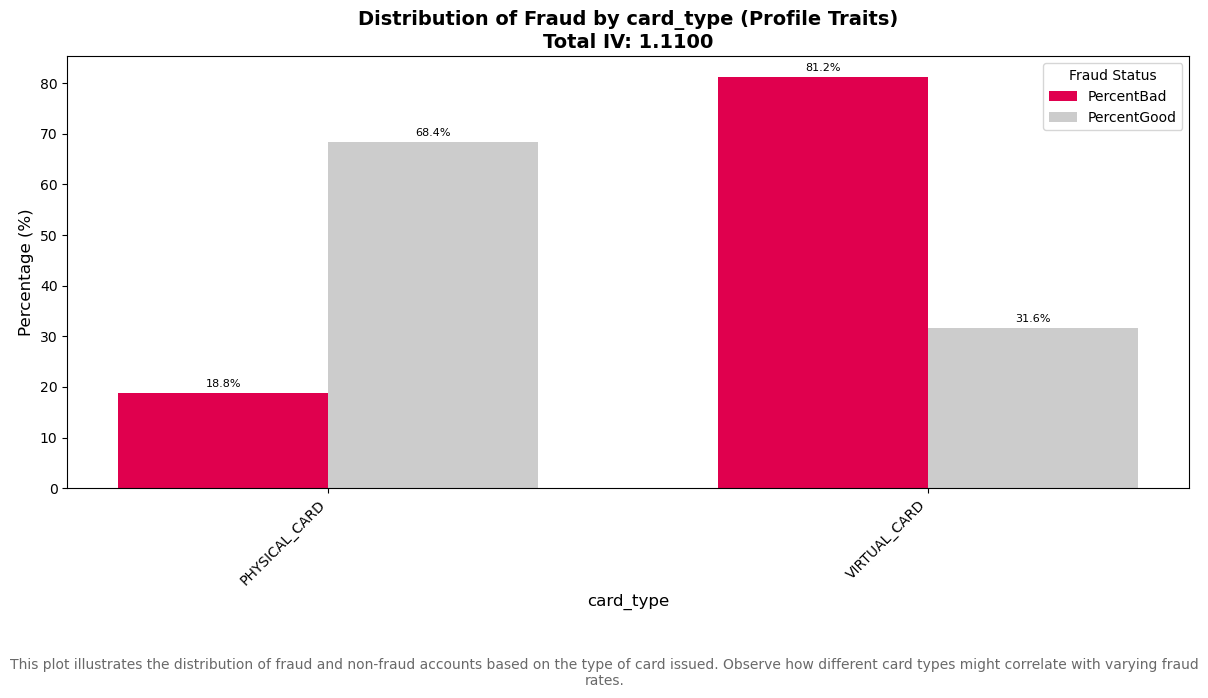

In [9]:
feature = "card_type"
category = "Profile Traits"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                description="This plot illustrates the distribution of fraud and non-fraud accounts based on the type of card issued. Observe how different card types might correlate with varying fraud rates.")